# Figures
Ovarian Cancer Reinforement Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
from scipy import stats
from openpyxl import load_workbook
import sidetable
from functools import reduce
import itertools
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import time
import statsmodels.api as sm
from scipy import stats
from lifelines import CoxPHFitter

device = torch.device('cpu')

## Table 1: Data Summary

In [2]:
# tcga_ov_1_keep = pd.read_csv('tcga_ov_1_keep.csv')
# tcga_ov_1_keep_d = pd.read_csv('tcga_ov_1_keep_d.csv')

# ############## Fix so that if a wb doesn't already exist it creates one

# book = load_workbook('./figs/Table_1.xlsx')
# book.template = False

# writer = pd.ExcelWriter('./figs/Table_1.xlsx', engine='openpyxl')
# writer.book = book

# ##################### All Patients
# # Race
# try:
#     del book['race']
# except:
#     pass
# tcga_ov_1_keep.stb.freq(['race']).to_excel(writer, sheet_name='race')

# # Tumor grade
# try:
#     del book['tumor grade']
# except:
#     pass
# tcga_ov_1_keep.stb.freq(['tumor_grade']).to_excel(writer, sheet_name='tumor grade')

# # Tumor stage
# try:
#     del book['tumor stage']
# except:
#     pass
# tcga_ov_1_keep.stb.freq(['tumor_stage']).to_excel(writer, sheet_name='tumor stage')

# # Death
# try:
#     del book['death']
# except:
#     pass
# tcga_ov_1_keep.stb.freq(['outcome_overall_survival_censoring']).to_excel(writer, sheet_name='death')
# # Age
# try:
#     del book['age']
# except:
#     pass
# pd.DataFrame(tcga_ov_1_keep['age_at_initial_pathologic_diagnosis'].describe()).to_excel(writer, sheet_name='age')

# # Overall survival
# try:
#     del book['days survival']
# except:
#     pass
# pd.DataFrame(tcga_ov_1_keep['total_days_overall_survival'].describe()).to_excel(writer, sheet_name='days survival')

# ##################### Deceased Patients
# # Race
# try:
#     del book['race_d']
# except:
#     pass
# tcga_ov_1_keep_d.stb.freq(['race']).to_excel(writer, sheet_name='race_d')

# # Tumor grade
# try:
#     del book['tumor grade_d']
# except:
#     pass
# tcga_ov_1_keep_d.stb.freq(['tumor_grade']).to_excel(writer, sheet_name='tumor grade_d')

# # Tumor stage
# try:
#     del book['tumor stage_d']
# except:
#     pass
# tcga_ov_1_keep_d.stb.freq(['tumor_stage']).to_excel(writer, sheet_name='tumor stage_d')

# # Age
# try:
#     del book['age_d']
# except:
#     pass
# pd.DataFrame(tcga_ov_1_keep_d['age_at_initial_pathologic_diagnosis'].describe()).to_excel(writer, sheet_name='age_d')

# # Overall survival
# try:
#     del book['days survival_d']
# except:
#     pass
# pd.DataFrame(tcga_ov_1_keep_d['total_days_overall_survival'].describe()).to_excel(writer, sheet_name='days survival_d')

# writer.save()
# writer.close()

## Figure 2a-2b: CPH Baseline Survival

2a: CPH Death Regression Baseline Survival

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


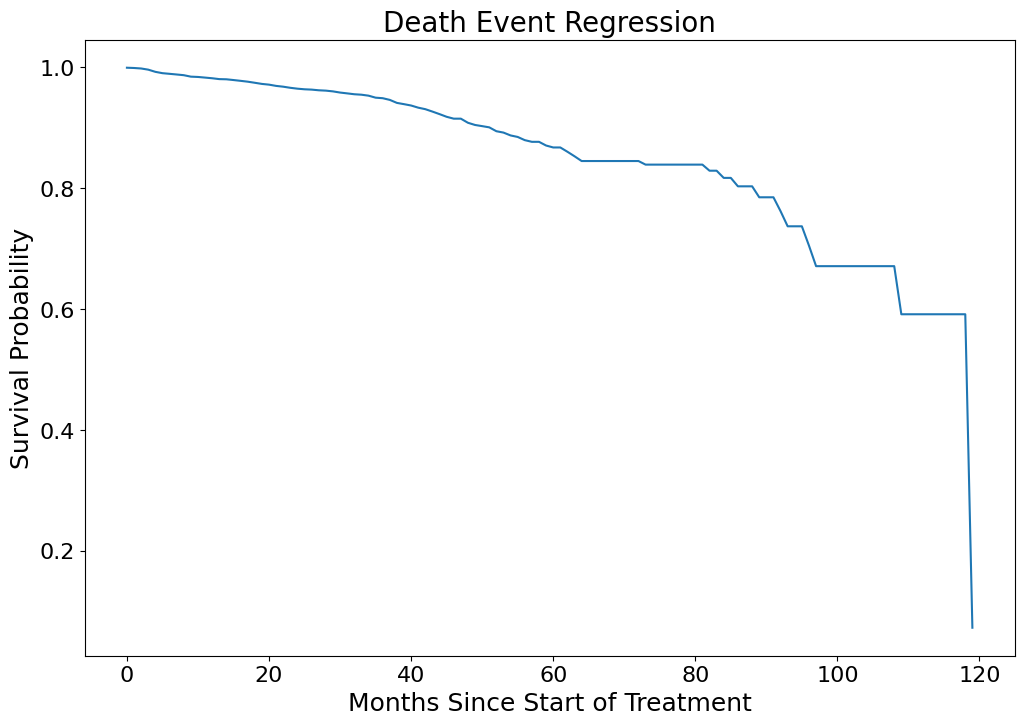

In [3]:
cph_surv_baseline = pd.read_csv('cph_surv_baseline.csv')
cph_treat_baseline = pd.read_csv('cph_treat_baseline.csv')

plt.style.use('default')
plt.figure(figsize=(12,8))
plt.rcParams['font.family'] = 'Arial'
# cph.plot_partial_effects_on_outcome(covariates='age', values=[40, 50, 60, 70, 80], cmap='coolwarm')
plt.plot(cph_surv_baseline)
plt.title('Death Event Regression', fontsize=20)
plt.xlabel('Months Since Start of Treatment', fontsize=18)
plt.ylabel('Survival Probability', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('./figs/res/Fig02a_baseline_surv_death.png', bbox_inches='tight')

2b: CPH Remission/Recurrence Regression Baseline Survival

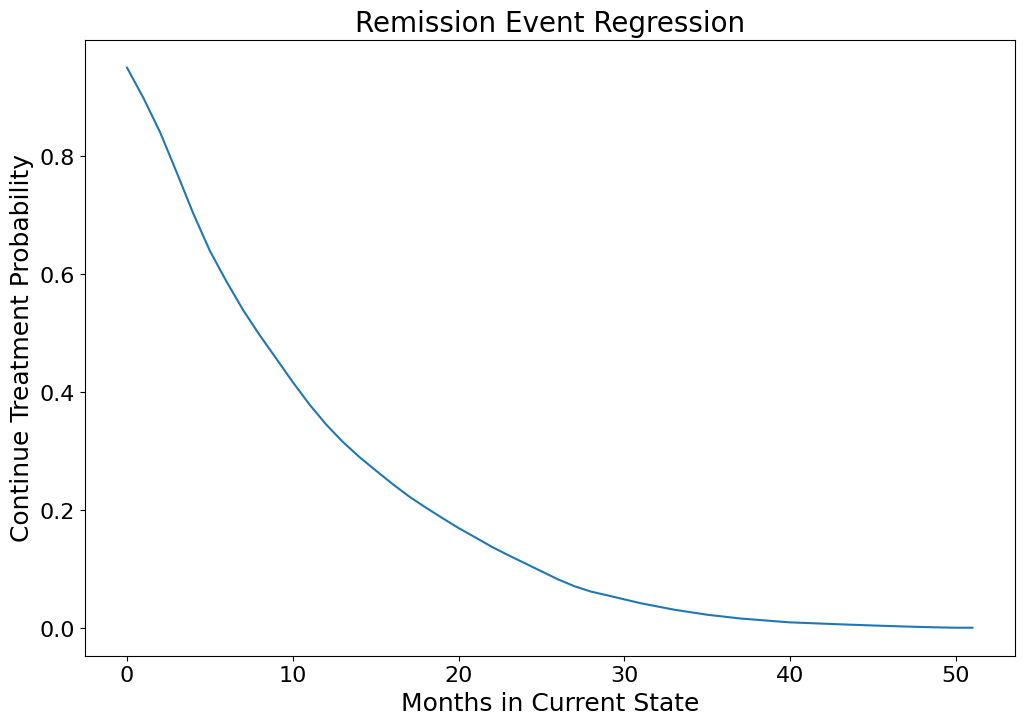

In [4]:
plt.style.use('default')
plt.figure(figsize=(12,8))
plt.rcParams['font.family'] = 'Arial'
plt.plot(cph_treat_baseline)
plt.title('Remission Event Regression', fontsize=20)
plt.xlabel('Months in Current State', fontsize=18)
plt.ylabel('Continue Treatment Probability', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('./figs/res/Fig02b_baseline_surv_recurrence.png', bbox_inches='tight')

## Figure 5a-5b: AI Policy Evaluation

5a: Simulated Patient Survival Training

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


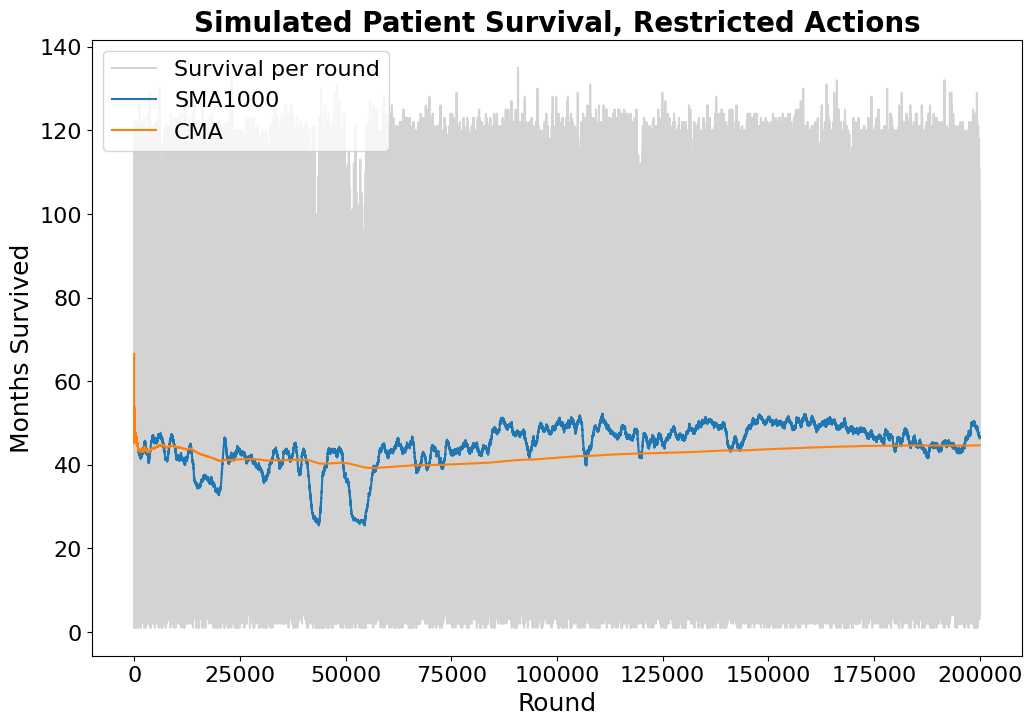

In [5]:
reward_df = pd.read_csv('reward_df_res.csv')

plt.figure(figsize=(12,8))
plt.rcParams["font.family"] = "Arial"
plt.plot(reward_df['mo_surv'], label='Survival per round', color='lightgray')
plt.plot(reward_df['SMA1000'], label='SMA1000')
plt.plot(reward_df['CMA'], label='CMA')
plt.title('Simulated Patient Survival, Restricted Actions', fontsize=20, fontweight='bold')
plt.xlabel('Round', fontsize=18)
plt.ylabel('Months Survived', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, loc='upper left')
plt.savefig('./figs/res/Fig05a_sim_survival.png', bbox_inches='tight')

5b: Estimated Policy Value Comparison

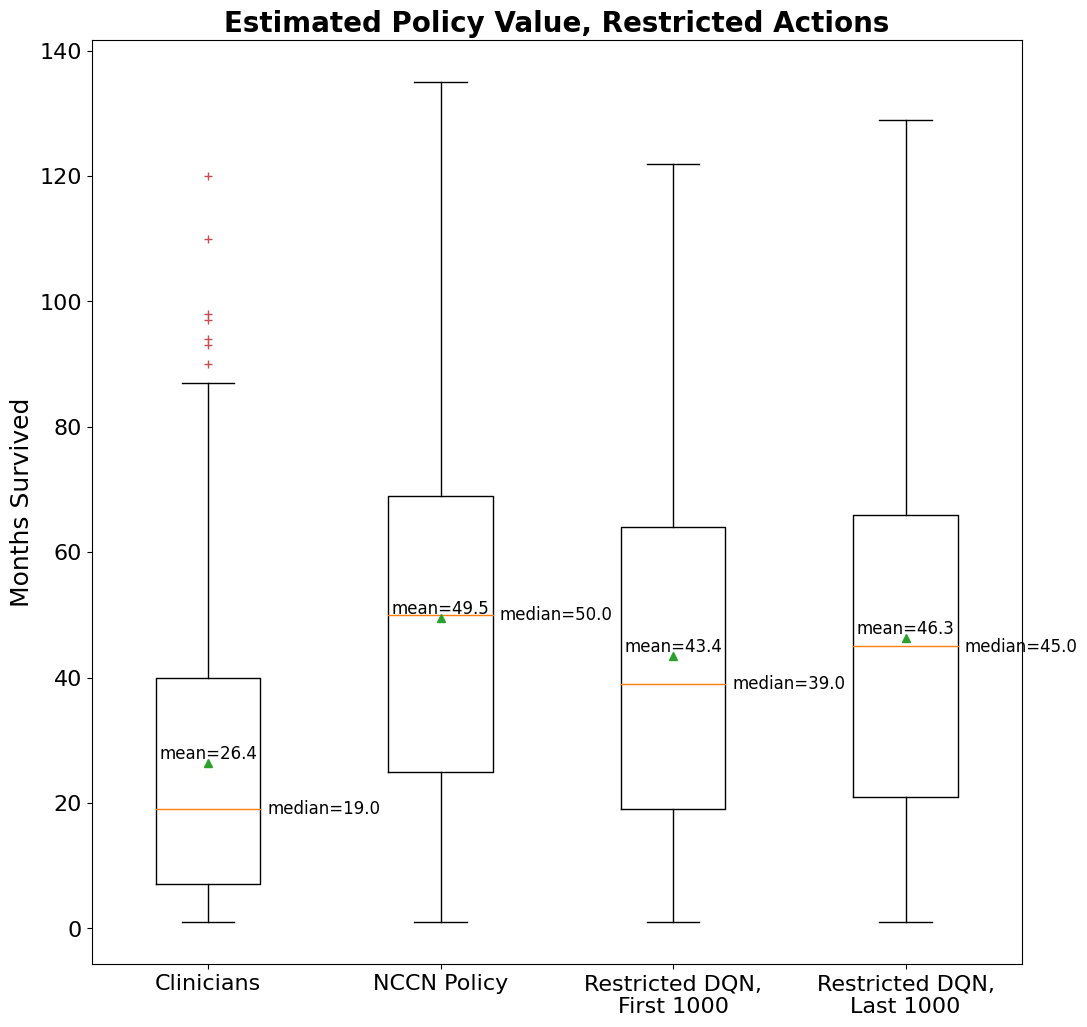

In [10]:
df_reg = pd.read_pickle('df_reg.pkl')
df_d_reg = pd.read_pickle('df_d_reg.pkl')
sim_trajectories = pd.read_csv('sim_trajectories_res.csv')
reward_df_nccn = pd.read_csv('reward_df_nccn.csv')

# Average value plots
    # Clinician data
clinician_val_d = df_d_reg[['patient', 'months']].groupby('patient').max()
clinician_val_d['months'] = clinician_val_d['months']+1 ####################
    # Simulation data
ai_val = reward_df['mo_surv'] ####################
    # NCCN data
nccn_val = reward_df_nccn['mo_surv']

plt.style.use('default')
plt.figure(figsize=(12,12))
bp = plt.boxplot([clinician_val_d['months'], nccn_val, ai_val[0:1000], ai_val[-1000:]],
                 labels=['Clinicians', 'NCCN Policy', 'Restricted DQN,\nFirst 1000', 'Restricted DQN,\nLast 1000'],
                 flierprops=dict(markeredgecolor='r', marker='+'),
                 showmeans=True,
                )
plt.title('Estimated Policy Value, Restricted Actions', fontsize=20, fontweight='bold')
plt.ylabel('Months Survived', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
for line in bp['means']:
    # get position data for median line
    x, y = line.get_xydata()[0] # top of median line
    # overlay median value
    plt.text(x-0.21, y+1.5, 'mean={:.1f}'.format(y), verticalalignment='center', fontsize=12)
for line in bp['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] 
    # overlay median value
    plt.text(x+0.03, y, 'median={:.1f}'.format(y), verticalalignment='center', fontsize=12)
    
plt.savefig('./figs/res/Fig05b_policy_val.png', bbox_inches='tight')

In [7]:
# P values
print('end vs. start: {:.3f}'.format(stats.ttest_ind(ai_val[0:1000], ai_val[-1000:])[1]))
print('end vs. clin: {:.3f}'.format(stats.ttest_ind(clinician_val_d['months'], ai_val[-1000:])[1]))
print('start vs. clin: {:.3f}'.format(stats.ttest_ind(clinician_val_d['months'], ai_val[0:1000])[1]))

print('nccn vs. clin: {:.3f}'.format(stats.ttest_ind(nccn_val, clinician_val_d['months'])[1]))
print('nccn vs. start: {:.3f}'.format(stats.ttest_ind(nccn_val, ai_val[0:1000])[1]))
print('nccn vs. end: {:.3f}'.format(stats.ttest_ind(nccn_val, ai_val[-1000:])[1]))

end vs. start: 0.021
end vs. clin: 0.000
start vs. clin: 0.000
nccn vs. clin: 0.000
nccn vs. start: 0.000
nccn vs. end: 0.000


## Figure 6a-6c: Treatment Frequency Heatmaps

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


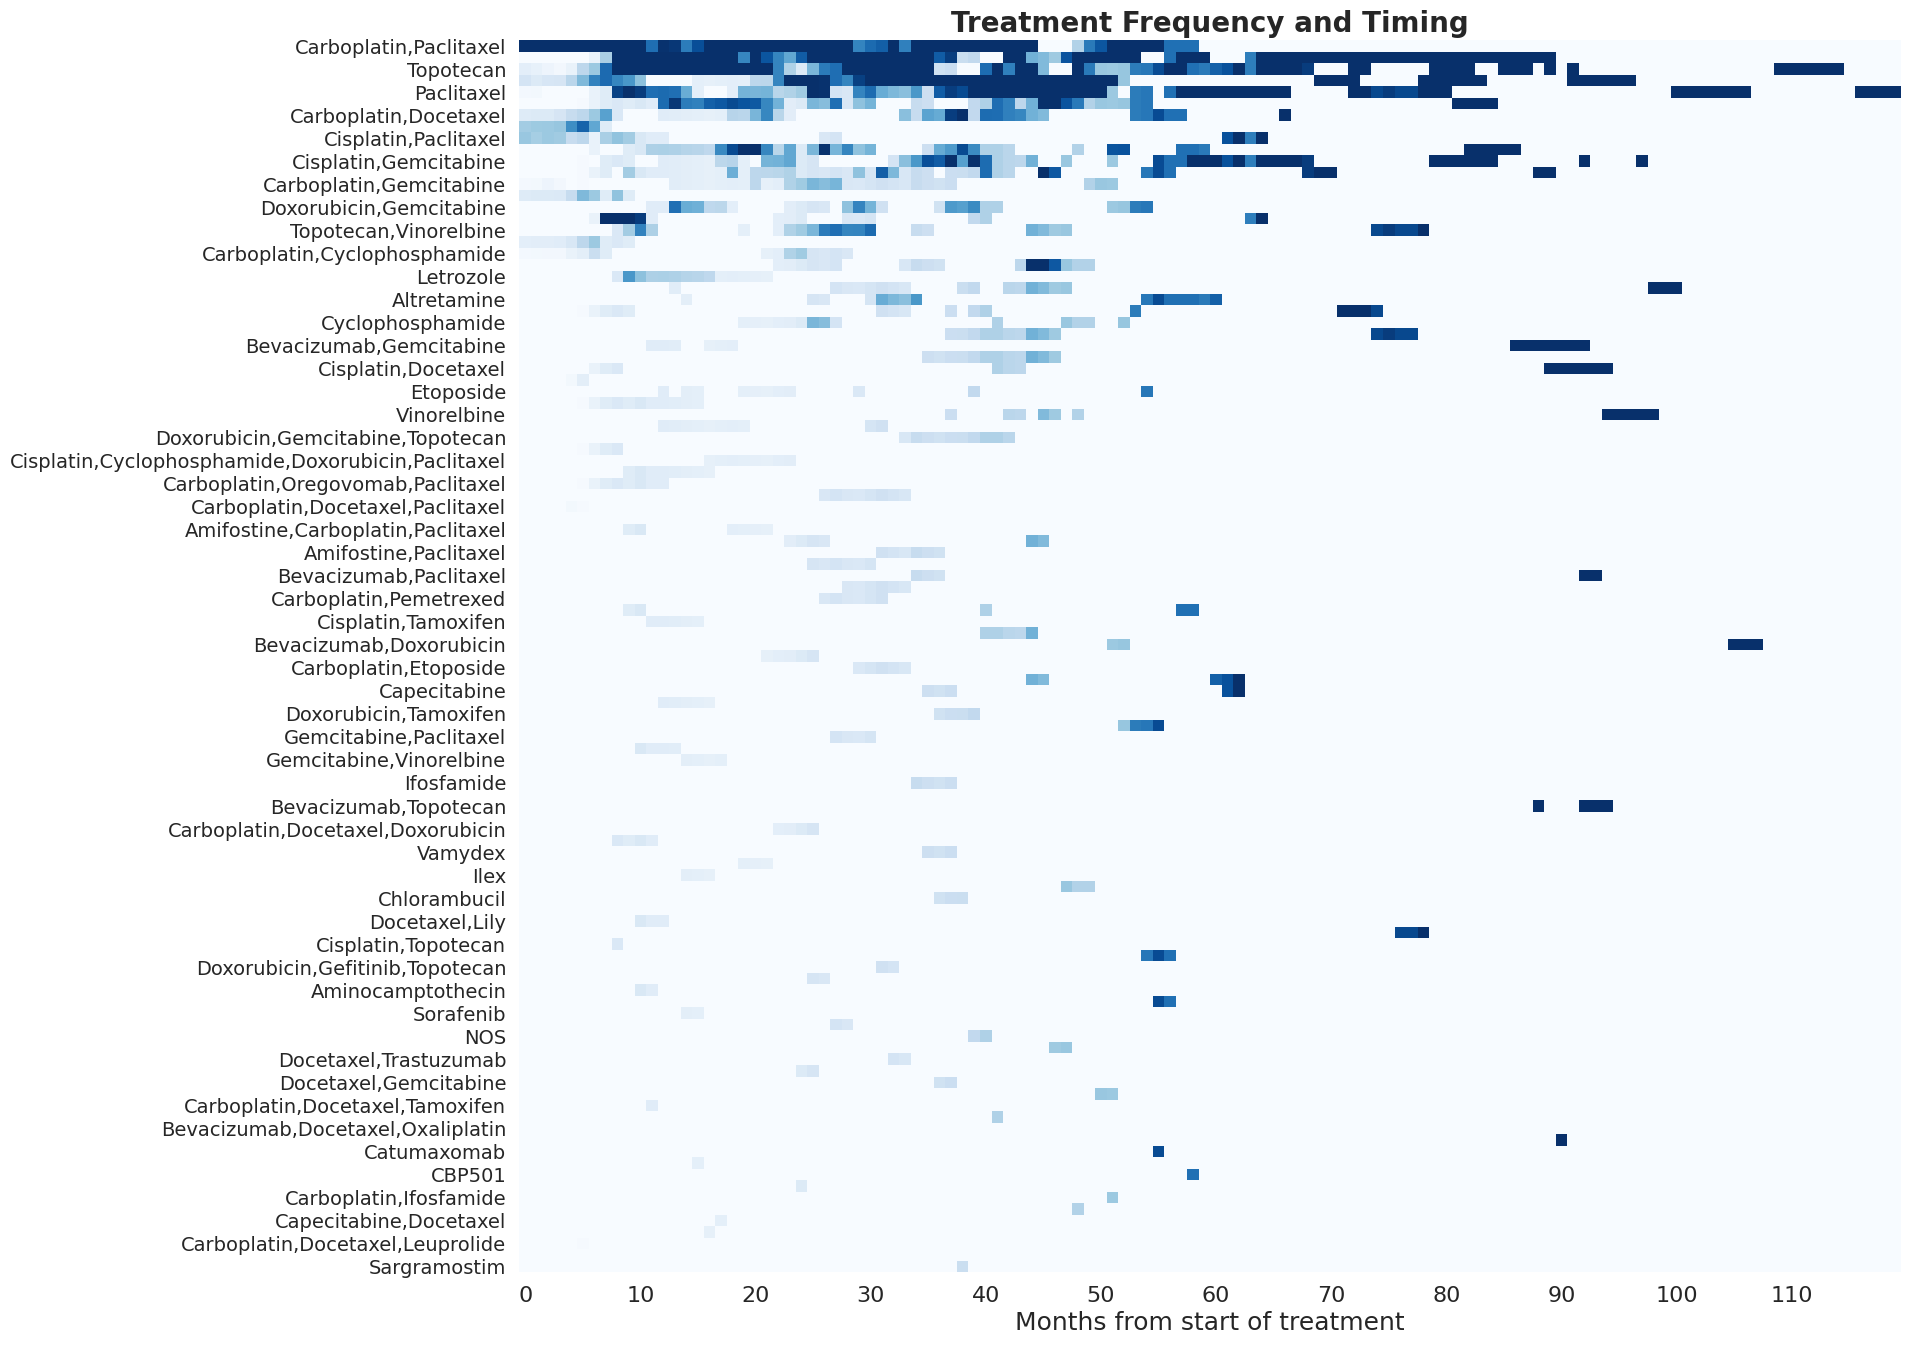

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


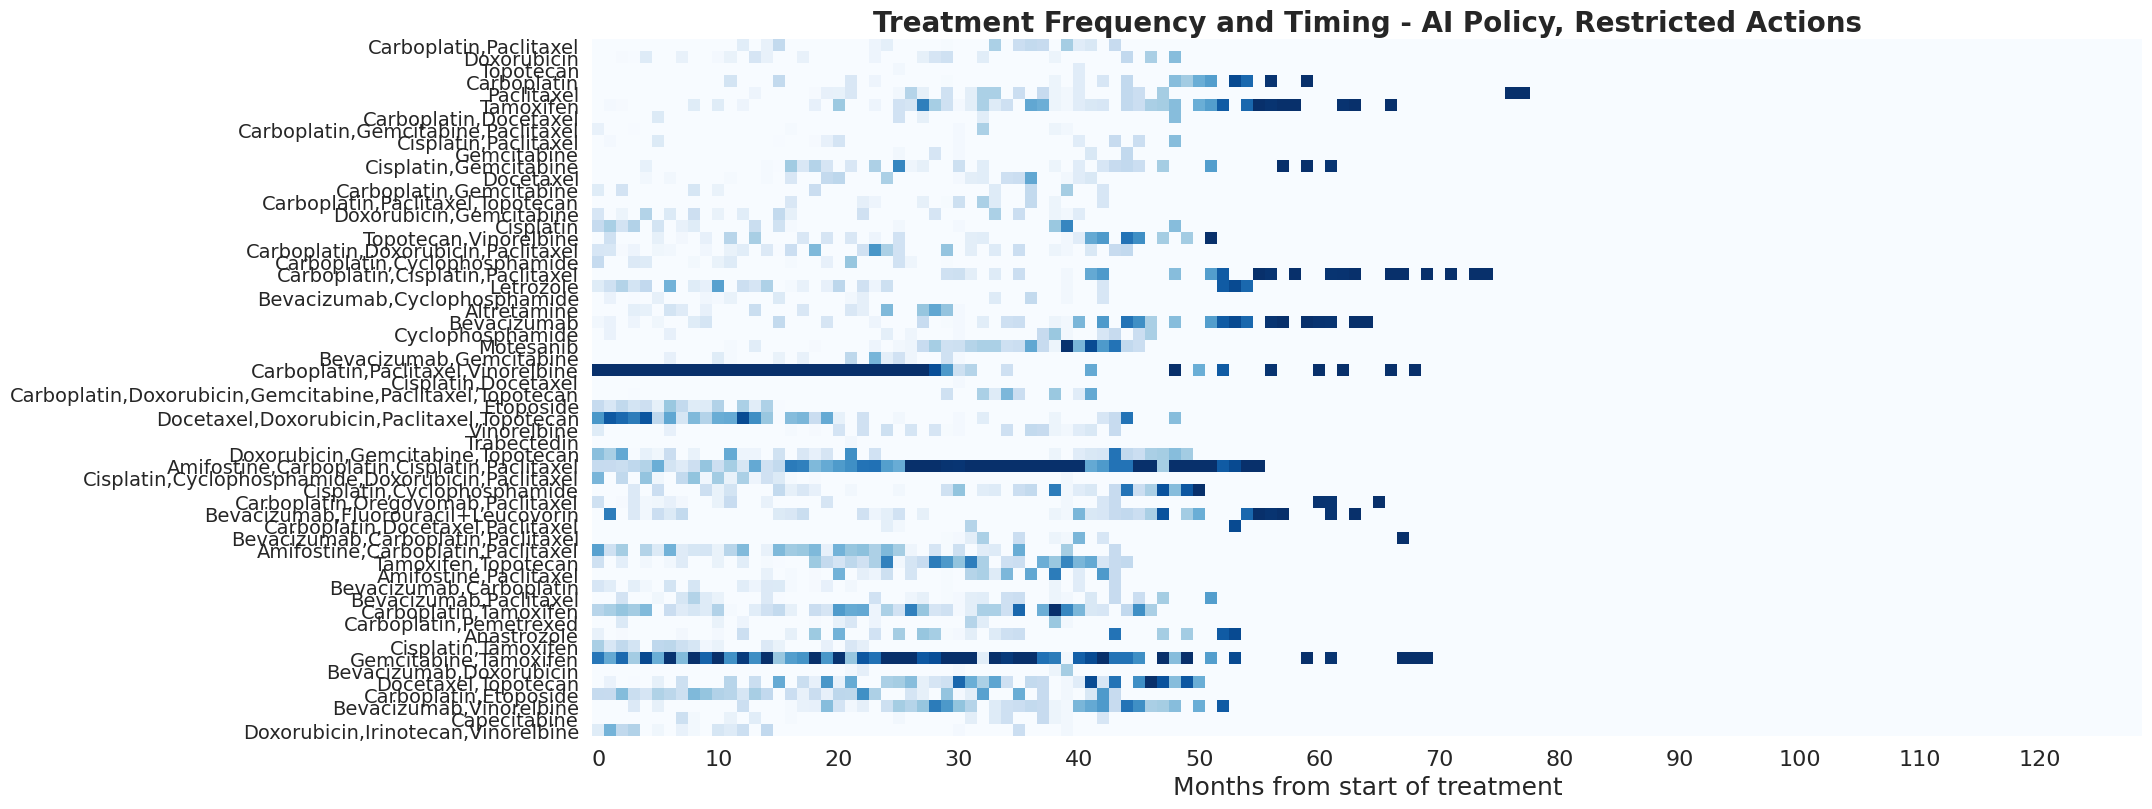

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


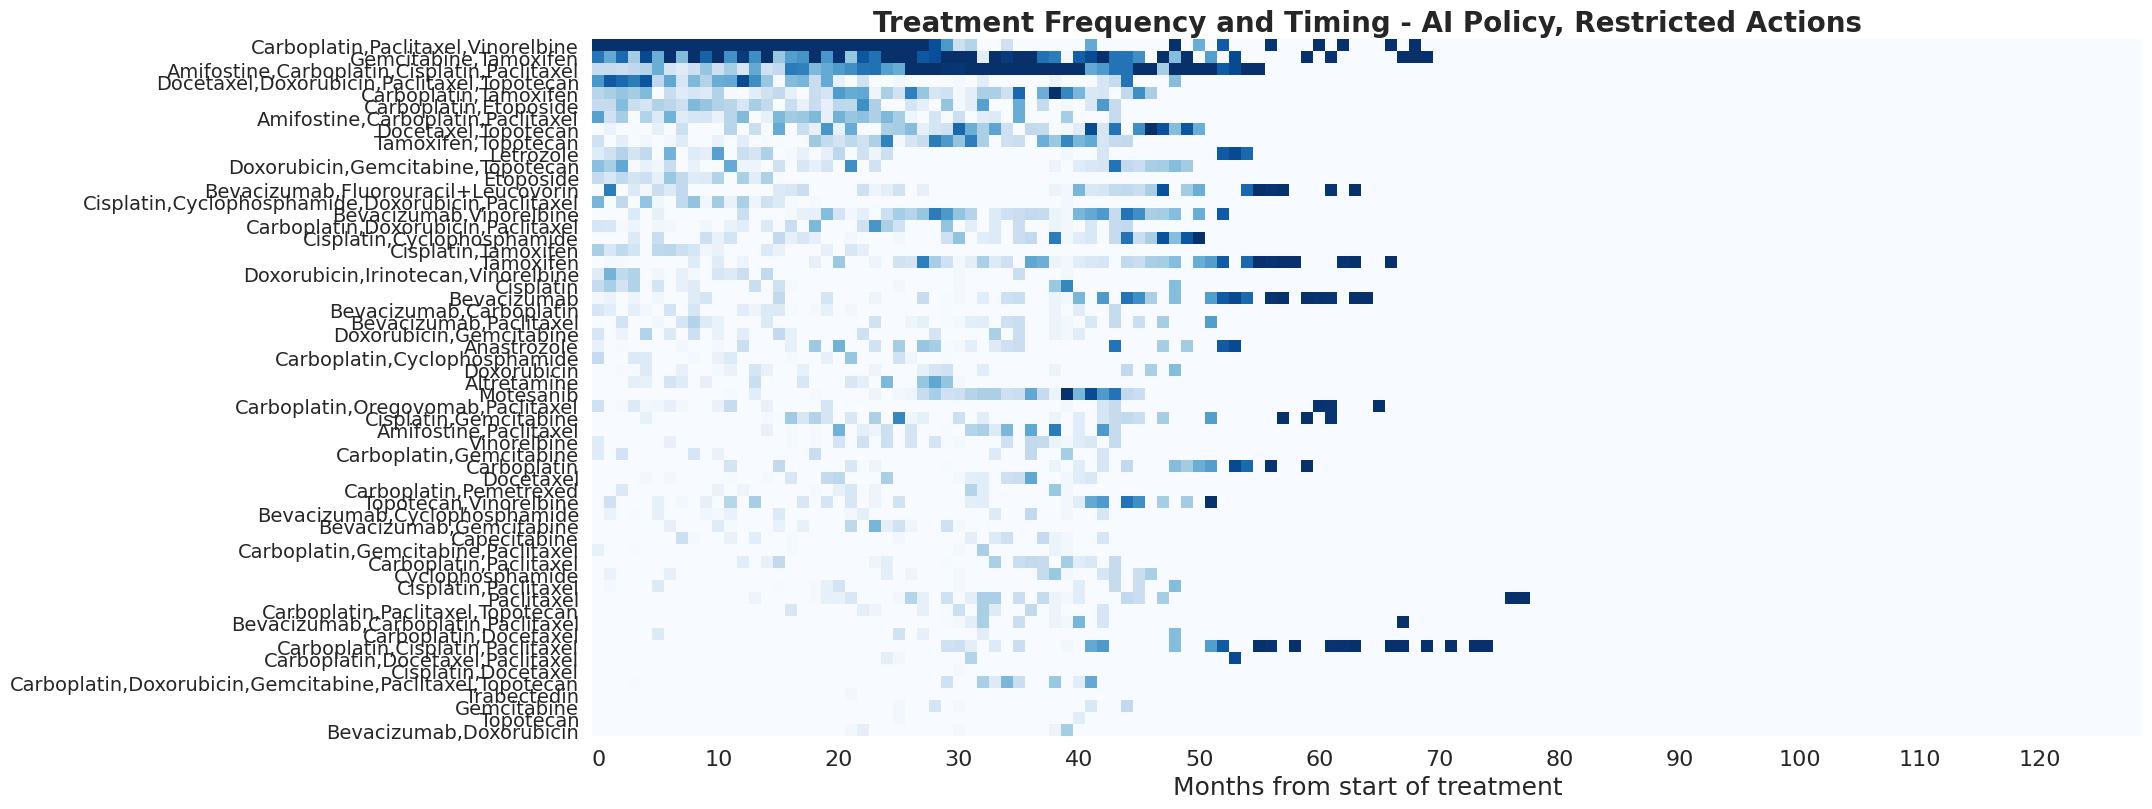

In [8]:
################# import sim_last1000.csv
sim_last1000 = pd.read_pickle('sim_last1000_res.pkl')

# Actual Data
df_heat = df_d_reg.stb.freq(['ther_str', 'months'])[['ther_str', 'months', 'count']].sort_values(by=['months', 'ther_str'])
df_heat = df_heat.pivot_table(index=['ther_str'], columns='months', values='count').reset_index().rename_axis(None, axis=1).set_index('ther_str')
df_heat = df_heat.fillna(value=0).drop([''], axis=0)
df_heat['sum_col'] = df_heat.sum(axis=1)
df_heat = df_heat.sort_values('sum_col', ascending=False).drop('sum_col', axis=1)

# Sim data
df_heat_sim = sim_last1000.stb.freq(['ther_str', 'months'])[['ther_str', 'months', 'count']].sort_values(by=['months', 'ther_str'])
df_heat_sim = df_heat_sim.pivot_table(index=['ther_str'], columns='months', values='count').reset_index().rename_axis(None, axis=1).set_index('ther_str')
df_heat_sim = df_heat_sim.fillna(value=0).drop([''], axis=0)
df_heat_sim = df_heat_sim.reindex(df_heat.index).dropna(how='all')

# Sim data sorted
df_heat_sim2 = sim_last1000.stb.freq(['ther_str', 'months'])[['ther_str', 'months', 'count']].sort_values(by=['months', 'ther_str'])
df_heat_sim2 = df_heat_sim2.pivot_table(index=['ther_str'], columns='months', values='count').reset_index().rename_axis(None, axis=1).set_index('ther_str')
df_heat_sim2 = df_heat_sim2.fillna(value=0).drop([''], axis=0)
df_heat_sim2['sum_col'] = df_heat_sim2.sum(axis=1)
df_heat_sim2 = df_heat_sim2.sort_values('sum_col', ascending=False).drop('sum_col', axis=1)

def freq_heat(data, fig_title, file_name):
    # convert to z-scores
    for col in data.columns:
        data[col] = stats.zscore(data[col])
    data = data.fillna(value=0)

    # Make heatmap
    sns.set(font_scale=1)

    cmap = sns.color_palette("Blues", as_cmap=True)
    plt.figure(figsize=(20,16))
    plt.rcParams["font.family"] = "Arial"
    ax = sns.heatmap(data=data,
                     cmap=cmap, 
                     square=1,
                     vmin=0, vmax=3,
                     xticklabels = 10,
    #                      cbar_kws={"shrink": .5},
                     cbar=False
                     )
    plt.title(fig_title, size=20, fontweight='bold')
    plt.xlabel('Months from start of treatment', size=18)
    plt.ylabel(None)
    plt.xticks(size=16, rotation=None)
    plt.yticks(size=14)
    plt.savefig(file_name, bbox_inches='tight')
    plt.show()

# freq_heat(df_reg, 'Treatment Frequency and Timing - All Patients', './figs/Fig06a_heat_data_all.png')
freq_heat(df_heat, 'Treatment Frequency and Timing', './figs/res/Fig06b_heat_data_d.png')
freq_heat(df_heat_sim, 'Treatment Frequency and Timing - AI Policy, Restricted Actions', './figs/res/Fig06c_heat_data_ai.png')
freq_heat(df_heat_sim2, 'Treatment Frequency and Timing - AI Policy, Restricted Actions', './figs/res/Fig06c2_heat_data_ai.png')

## Figure 7: Treatment lines frequency bar

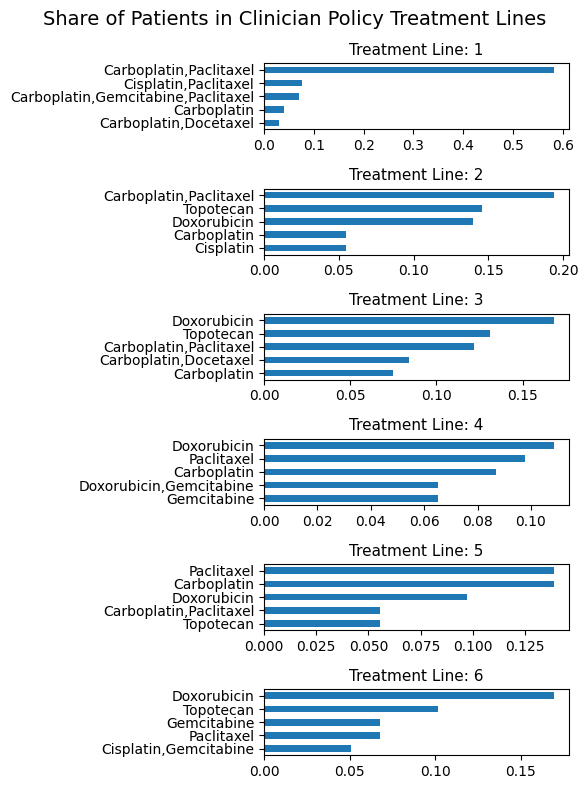

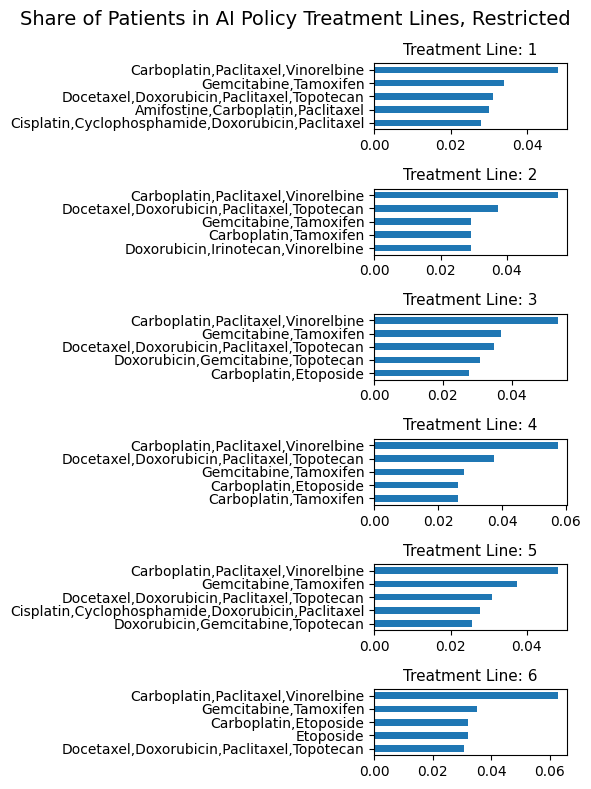

In [9]:
def treat_lines(data, title, file_name):
    freq_l1000 = data.drop_duplicates(['patient', 'ther_str', 'previous_lines']).groupby(['ther_str', 'previous_lines']).count().reset_index()
    freq_l1000 = freq_l1000.loc[freq_l1000['ther_str'] != ''].sort_values(['previous_lines', 'patient'], ascending=(True, False))
    freq_l1000 = freq_l1000.loc[freq_l1000['previous_lines'] < 10][['ther_str', 'previous_lines', 'patient']].reset_index(drop=True)
    freq_l1000 = freq_l1000.pivot(index='previous_lines', columns='ther_str', values='patient').fillna(value=0).reset_index().rename_axis(None, axis=1)
    cols = list(freq_l1000.drop('previous_lines', axis=1).columns)
    freq_l1000['sum_col'] = freq_l1000.sum(axis=1)
    freq_l1000[cols] = freq_l1000[cols].div(freq_l1000['sum_col'], axis=0)
    freq_l1000 = freq_l1000.drop(['sum_col', 'previous_lines'], axis=1)

    plt.style.use('default')
    fig, axs = plt.subplots(6, figsize=(6,8))
    fig.suptitle(title, fontsize=14)
    for row in range(0,6):
        freq_line = pd.DataFrame(freq_l1000.iloc[row].sort_values(ascending=False))
        freq_line = freq_line.head(5).sort_values(by=row)
        freq_line.plot(ax=axs[row], kind='barh', title='Treatment Line: {}'.format(row+1), legend=False, sharey=True)
        axs[row].title.set_size(11)
    fig.tight_layout()
    plt.savefig(file_name, bbox_inches='tight')
    plt.show()

treat_lines(df_d_reg, 'Share of Patients in Clinician Policy Treatment Lines', './figs/res/Fig07a_lines_clin.png')
treat_lines(sim_last1000, 'Share of Patients in AI Policy Treatment Lines, Restricted', './figs/res/Fig07b_lines_ai.png')